In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os


In [3]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00


Let's now count the number of total videos we have.

In [4]:
import pathlib
dataset_root_path = pathlib.Path("./drive/MyDrive/DSA4266 Project")

In [5]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.mp4")))
video_count_val = len(list(dataset_root_path.glob("validation/*/*.mp4")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.mp4")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 5500


In [6]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.mp4"))
    + list(dataset_root_path.glob("validation/*/*.mp4"))
    + list(dataset_root_path.glob("test/*/*.mp4"))
)
all_video_file_paths[:5]

[PosixPath('drive/MyDrive/DSA4266 Project/train/deepfake/lbooddsyfl.mp4'),
 PosixPath('drive/MyDrive/DSA4266 Project/train/deepfake/lbpfomllae.mp4'),
 PosixPath('drive/MyDrive/DSA4266 Project/train/deepfake/lcmjyjdbqn.mp4'),
 PosixPath('drive/MyDrive/DSA4266 Project/train/deepfake/lclyxqctwg.mp4'),
 PosixPath('drive/MyDrive/DSA4266 Project/train/deepfake/lcegpefqvk.mp4')]

In [7]:
class_labels = sorted({str(path).split("/")[4] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['deepfake', 'real'].


### Loading the model

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import *

# Define CNN model architecture with skip connections

def conv_block(x, filter):
    # Layer 1
    x_skip = x
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])    # Skip connection
    x = tf.keras.layers.Activation('relu')(x)
    return x



def create_resnet_model(hp):
    strides = hp.Int('strides', min_value=1, max_value=3, step=2)
    kernel_size = hp.Int('kernel_size', min_value=3, max_value=5, step=2)
    filters = 64
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.layers.ZeroPadding2D((3, 3))(inputs) # add padding
    x = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x) # always doing this
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=strides, padding='same')(x)

    # number of filters will increase deeper into the model
    for i in range(5):
        filters = filters << 1
        x = conv_block(x, filters)

    # Flatten and dense layers
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu')(x)

    outputs = Dense(1, activation='sigmoid')(x)  # binary

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy']) # always use adam

    return model


    # model.fit(train_data, train_labels, epochs=10, validation_data=(val_data, val_labels))

In [9]:
import os

import cv2
from tqdm import tqdm

# Functions adapted from Junhui's cnn_dev.ipynb
# (Print statements removed to allow tqdm to work)

pth = "./drive/MyDrive/DSA4266 Project/"

import os

import cv2
from tqdm import tqdm

# Functions adapted from Junhui's cnn_dev.ipynb
# (Print statements removed to allow tqdm to work)


def load_video(video_name, folder_path="../../data/train_sample_videos"):
    video_path = os.path.join(folder_path, video_name)
    cap = cv2.VideoCapture(video_path)
    return cap


def extract_frames(cap, frame_interval=1):
    frames = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            resized_frame = cv2.resize(frame, (224, 224)) / 255.0
            frames.append(resized_frame)

        frame_count += 1

    return frames


def save_frames(frames, output_folder="./extracted_frames"):
    os.makedirs(output_folder, exist_ok=True)

    for frame_count, frame in enumerate(frames):
        output_path = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(output_path, (frame * 255).astype("uint8"))


def extract_and_save_videos(input_dir, output_dir):
    filenames = sorted(os.listdir(input_dir))
    for filename in tqdm(filenames):
        if not filename.endswith((".mp4")):
            continue
        cap = load_video(filename, input_dir)
        frames = extract_frames(cap)
        video_output_dir = os.path.join(output_dir, filename[:-4])
        save_frames(frames, video_output_dir)

categories = ["train", "test", "validation"]
for cat in categories:
    extract_and_save_videos(f"{pth}{cat}/deepfake", f"FRAMES/{cat}_frames/deepfake")
    extract_and_save_videos(f"{pth}{cat}/real", f"FRAMES/{cat}_frames/real")

100%|██████████| 412/412 [02:02<00:00,  3.35it/s]


In [ ]:
import keras_tuner as kt

tuner = kt.RandomSearch(
    create_resnet_model,
    objective='val_accuracy',
    max_trials=4,
    executions_per_trial=1,
    directory='DIR',
    project_name='Resnet'
)

In [ ]:
import os
import random
from typing import Any, Callable, Optional

import cv2
import numpy as np
from tqdm import tqdm


def rotate_frame(frame: np.ndarray, angle: float) -> np.ndarray:
    """
    Rotates the given `frame` by the angle `angle`.

    Args:
        frame (np.ndarray): Original frame to be transformed.
        angle (float): Angle to rotate the frame by.

    Returns:
        Rotated array of type `np.ndarray`.
    """
    height, width = frame.shape[:2]
    center = (width // 2, height // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(frame, matrix, (width, height))
    return rotated


def adjust_brightness_contrast(
    frame: np.ndarray, brightness: float = 0.0, contrast: float = 0.0
) -> np.ndarray:
    """
    Adjusts the brightness and contrast of a frame.

    Args:
        frame (np.ndarray): Original frame to be transformed.
        brightness (float): Amount to increase the brightness by.
        contrast (float): Amount fo increase the contrast by.

    Returns:
        Modified array of type `np.ndarray`.
    """
    frame = np.clip(frame * (1 + contrast / 100.0) + brightness, 0, 255).astype(
        np.uint8
    )
    return frame


def flip_frame(frame: np.ndarray, flip_code: int) -> np.ndarray:
    """
    Flips the frame.

    Args:
        frame (np.ndarray): Original frame to be transformed.
        flip_code (int): Flip code; 1 for vertical flip and 0 for horizontal flip.

    Returns:
        Flipped frame of type `np.ndarray`.
    """
    return cv2.flip(frame, flip_code)


def transform(
    input_path: str,
    output_path: str,
    transformation: Callable[[np.ndarray, Optional[Any], Optional[Any]], np.ndarray],
) -> None:
    """
    Applies a single random transformation to the frame, then saves the result.
    Note that there is an identity transformation which keeps the frame the same.

    Args:
        input_path (str): Input path as a string.
        output_path (str): Output path as a string.
        transformation (Callable[[np.ndarray], np.ndarray])

    Returns:
        None
    """
    frame = cv2.imread(input_path)
    transformed_frame = transformation(frame)
    transformed_frame = transformed_frame.astype(np.uint8)
    cv2.imwrite(output_path, transformed_frame)


def augment_frame(
    input_dir: str | bytes | os.PathLike,
    output_dir: str | bytes | os.PathLike,
    filename: str,
) -> None:
    """
    Augments the frame by applying one random transformation and saves it.
    Note that there is an identity transformation which keeps the frame the same.

    Args:
        input_dir (str | bytes | os.PathLike): Input directory.
        output_dir (str | bytes | os.PathLike): Output directory.
        filename (str): File to be augmented.

    Returns:
        None
    """
    input_path = os.path.join(input_dir, filename)
    os.makedirs(output_dir, exist_ok=True)

    transformations = [
        lambda frame: frame,
        lambda frame: rotate_frame(frame, 90),
        lambda frame: rotate_frame(frame, 180),
        lambda frame: rotate_frame(frame, 270),
        lambda frame: adjust_brightness_contrast(frame, brightness=-25),
        lambda frame: adjust_brightness_contrast(frame, brightness=25),
        lambda frame: adjust_brightness_contrast(frame, contrast=-25),
        lambda frame: adjust_brightness_contrast(frame, contrast=25),
        lambda frame: flip_frame(frame, 1),
        lambda frame: flip_frame(frame, 0),
    ]

    transformation_fn = random.choice(transformations)
    output_path = os.path.join(output_dir, filename)
    transform(input_path, output_path, transformation_fn)


def augment_frames(
    input_dir: str | bytes | os.PathLike, output_dir: str | bytes | os.PathLike
) -> None:
    """
    Augments frames by applying a random augmentation to each one.

    Args:
        input_dir (str | bytes | os.PathLike): Input directory containing the original frames.
        output_dir (str | bytes | os.PathLike): Output directory to save the augmented frames to.

    Returns:
        None
    """
    filenames = sorted(os.listdir(input_dir))
    random.seed(42)
    for filename in tqdm(filenames):
        if filename == ".DS_Store":
            continue
        video_dir = os.path.join(input_dir, filename)
        video_output_dir = os.path.join(output_dir, filename)
        frames = sorted(os.listdir(video_dir))
        for frame in frames:
            augment_frame(video_dir, video_output_dir, frame)


categories = ["train", "validation"]
for cat in categories:
    augment_frames(
        f"FRAMES/{cat}_frames/deepfake", f"AUGMENTED/{cat}_frames_augmented/deepfake"
    )
    augment_frames(f"FRAMES/{cat}_frames/real", f"AUGMENTED/{cat}_frames_augmented/real")

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "AUGMENTED/train_frames_augmented/",
    labels="inferred",  # Automatically labels based on subdirectory names
    label_mode="binary",  # For binary classification (0 and 1)
    batch_size=32,  # Set your batch size
    image_size=(224, 224),  # Resize images to a consistent size (e.g., 224x224)
    shuffle=True,  # Shuffle the dataset
    seed=42  # Set a seed for reproducibility
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "AUGMENTED/validation_frames_augmented/",
    labels="inferred",  # Automatically labels based on subdirectory names
    label_mode="binary",  # For binary classification (0 and 1)
    batch_size=32,  # Set your batch size
    image_size=(224, 224),  # Resize images to a consistent size (e.g., 224x224)
    shuffle=True,  # Shuffle the dataset
    seed=42  # Set a seed for reproducibility
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "FRAMES/test_frames/",
    labels="inferred",  # Automatically labels based on subdirectory names
    label_mode="binary",  # For binary classification (0 and 1)
    batch_size=32,  # Set your batch size
    image_size=(224, 224),  # Resize images to a consistent size (e.g., 224x224)
    shuffle=False,
    seed=42  # Set a seed for reproducibility
)





In [ ]:
train_dataset.class_names == test_dataset.class_names == val_dataset.class_names

In [ ]:
# Start the hyperparameter search
tuner.search(train_dataset, epochs=3, validation_data=val_dataset)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    'best_model.keras', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min'
)


history = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=7,
    callbacks=[checkpoint_callback]
)

# Load the best model from the file
from tensorflow.keras.models import load_model
best_model = load_model('best_model.keras')


In [ ]:
best_model.save("best_model.keras")


In [ ]:
from google.colab import files
files.download("best_model.keras")

## Inference

In [10]:
!pip install -U -q tensorflow
!pip install -U -q keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [11]:
from tensorflow.keras.models import load_model
import tensorflow as tf
best_model = load_model('best_model.keras')

In [12]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "FRAMES/test_frames/",
    labels="inferred",
    label_mode="binary",
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,  # Don't shuffle is the diff here.
    seed=42
)


Found 326064 files belonging to 2 classes.


In [13]:
predictions = best_model.predict(test_dataset)


10190/10190 ━━━━━━━━━━━━━━━━━━━━ 206s 20ms/step


In [16]:
import pandas as pd
import numpy as np

In [17]:
predicted_labels = np.round(predictions).flatten()

# Collect true labels and predicted labels
true_labels_list = []
predicted_labels_list = []

for images, true_labels in test_dataset:
    true_labels_list.extend(true_labels.numpy().flatten())  # Collect true labels
    predicted_labels_list.extend(predicted_labels[:len(true_labels)])  # Collect predictions
    predicted_labels = predicted_labels[len(true_labels):]  # Remove used predictions

# Create a DataFrame
results_df = pd.DataFrame({
    "Actual": true_labels_list,
    "Predicted": predicted_labels_list
})


In [18]:
results_df

,Actual,Predicted
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
326059,1.0,1.0
326060,1.0,1.0
326061,1.0,1.0
326062,1.0,1.0


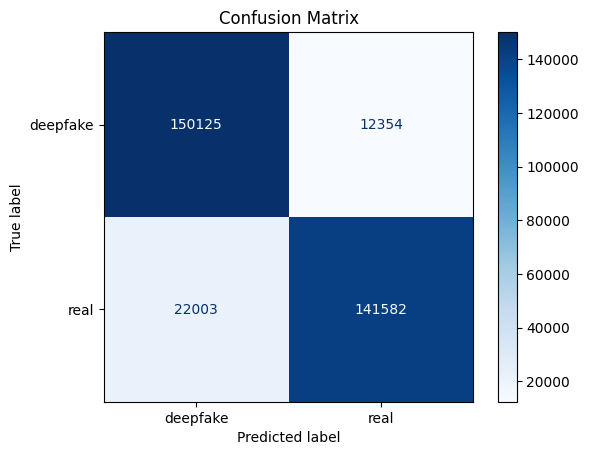

              precision    recall  f1-score   support

    deepfake       0.87      0.92      0.90    162479
        real       0.92      0.87      0.89    163585

    accuracy                           0.89    326064
   macro avg       0.90      0.89      0.89    326064
weighted avg       0.90      0.89      0.89    326064



In [19]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def plot_confusion_matrix(results_df, class_labels=class_labels):
    labels = class_labels
    cm = confusion_matrix(results_df["Actual"], results_df["Predicted"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)  # Use class_labels for display
    disp.plot(cmap="Blues")  # Customize the colormap if desired
    plt.title("Confusion Matrix")
    plt.show()
    report = classification_report(results_df["Actual"], results_df["Predicted"], target_names=labels)
    print(report)

plot_confusion_matrix(results_df)

That was just on frames, now on video which is the main mission

In [20]:
import os
from tqdm import tqdm

def load_image(file_name):
  raw = tf.io.read_file(file_name)
  tensor = tf.io.decode_image(raw)
  tensor = tf.cast(tensor, tf.float32)
  return tensor


def create_dataset(file_names, vidlabel):
  labels = [vidlabel] * len(file_names)
  dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))
  dataset = dataset.map(lambda file_name, label: (load_image(file_name), label))
  return dataset.batch(32)

deep = "./FRAMES/test_frames/deepfake/"
deepfaked_vids = os.listdir(deep)
real = "./FRAMES/test_frames/real/"
real_vids = os.listdir(real)

def predict(label=0):
    p = []
    if not label:
        vids = deepfaked_vids
        pth = deep
    else:
        vids = real_vids
        pth = real

    for vid in tqdm(vids):
        images = [os.path.join(pth+vid, fname) for fname in os.listdir(pth+vid)
        if fname.lower().endswith('.jpg')]
        video = create_dataset(images, label)
        p.append(np.round(np.mean(best_model.predict(video, verbose=0))))
    return p

predictions_for_real = predict(1)
predictions_for_deep = predict(0)


100%|██████████| 550/550 [02:00<00:00,  4.55it/s]


In [21]:
predictions_for_real = np.array(predictions_for_real)
predictions_for_deep = np.array(predictions_for_deep)


In [22]:
df_real = pd.DataFrame({'Predicted': predictions_for_real})
df_deep = pd.DataFrame({'Predicted': predictions_for_deep})
df_real['Actual'] = [1.0 for i in range(len(df_real))]
df_deep['Actual'] = [0.0 for i in range(len(df_deep))]

df = pd.concat([df_real, df_deep])
df.reset_index(drop=True, inplace=True)
df.to_csv('results.csv', index=False)

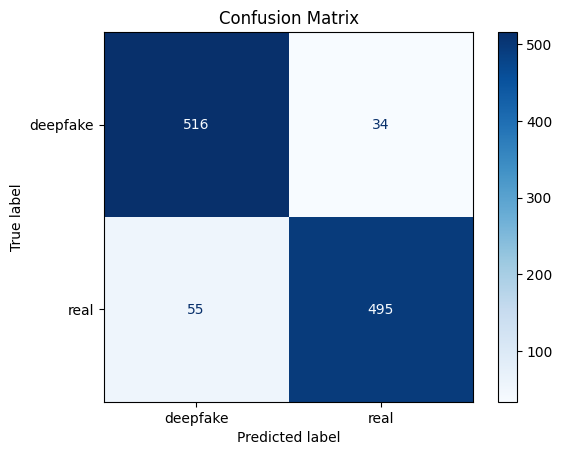

              precision    recall  f1-score   support

    deepfake       0.90      0.94      0.92       550
        real       0.94      0.90      0.92       550

    accuracy                           0.92      1100
   macro avg       0.92      0.92      0.92      1100
weighted avg       0.92      0.92      0.92      1100



In [23]:
# nah its not subject to license i defined this
plot_confusion_matrix(df)